In [732]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve
import pickle

In [733]:
df = pd.read_csv("draft_df_cleaned.csv", index_col=0)

df['ThreePPercent'] = pd.to_numeric(df['ThreePPercent'], errors='coerce')
df["TSPercent"] = ((df.PTS*0.5)/(df.FGA+(0.475*df.FTA)))

df['FTRate'] = df.FTA/df.FGA
df = df.replace(r'^\s*$', np.NaN, regex=True)
df['FTRate'] = df['FTRate'].apply(lambda x: 0 if x == 'inf' or x == '-inf' or x == 'NaN' else (mx if x > mx else x))

nomc_cols_features = ['PLAYER', 'ROOKIE', 'ROTY', 'FTM', 'AST', 'STL', 'OREB', 'GP', 'BLK', 'PF', 'ThreePA', 'FTPercent', 'ThreePPercent', 'GUARD', \
             'FORWARD', 'WEIGHT', 'HEIGHT', 'CENTER', 'YEAR', 'OVERALL PICK', 'FTRate', 'TSPercent']
#cols with advanced stats

dfwfeatures = df[nomc_cols_features]

nomc_cols = ["ROTY", "PLAYER", "ROOKIE", "FTA", "AST", "DREB", "STL", "OREB", "GP", "BLK", "PF", "ThreePM", "FTPercent", \
             "ThreePPercent", "FGPercent", "GUARD", "FORWARD", "WEIGHT", "HEIGHT", "CENTER", "YEAR", "OVERALL PICK"]
#cols without advanced stats

dfwof = df[nomc_cols]

dfwfeatures.fillna(0, inplace=True)

dfwfeatures.to_csv("cleaned_data2.csv")

C:\Users\asimp\anaconda3\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [734]:
dfwof #data without advanced stats

,ROTY,PLAYER,ROOKIE,FTA,AST,DREB,STL,OREB,GP,BLK,...,FTPercent,ThreePPercent,FGPercent,GUARD,FORWARD,WEIGHT,HEIGHT,CENTER,YEAR,OVERALL PICK
0,0,Kwame Brown,0,1.7,0.8,2.4,0.3,1.1,57.0,0.5,...,70.7,0.0,38.7,0,0,132.0,2.11,1,2001,1
1,0,Tyson Chandler,0,3.1,0.8,3.2,0.4,1.6,71.0,1.3,...,60.4,0.0,49.7,0,0,107.0,2.13,1,2001,2
2,1,Pau Gasol,0,5.8,2.7,6.0,0.5,2.9,82.0,2.1,...,70.9,20.0,51.8,0,1,113.0,2.13,1,2001,3
3,0,Jason Richardson,0,2.6,3.0,2.7,1.3,1.6,80.0,0.4,...,67.1,33.3,42.6,1,0,102.0,1.98,0,2001,5
4,0,Shane Battier,0,3.6,2.8,3.1,1.6,2.3,78.0,1.0,...,70.0,37.3,42.9,0,1,100.0,2.03,0,2001,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,0,Kendall Brown,1,2.2,1.9,3.1,1.0,1.7,34.0,0.4,...,68.9,34.1,58.4,1,0,93.0,2.03,0,2022,48
889,0,Isaiah Mobley,1,2.3,1.0,3.7,0.6,1.5,31.0,0.6,...,52.1,28.6,47.4,0,1,108.0,2.03,0,2022,49
890,0,Tyrese Martin,1,1.6,1.0,3.3,0.8,1.9,33.0,0.3,...,64.8,31.1,41.8,1,0,98.0,1.98,0,2022,51
891,0,JD Davison,1,2.5,4.3,3.7,1.0,1.1,33.0,0.4,...,72.8,30.1,46.3,1,0,88.0,1.91,0,2022,53


In [735]:
dfwfeatures #data with advanced stats

,PLAYER,ROOKIE,ROTY,FTM,AST,STL,OREB,GP,BLK,PF,...,ThreePPercent,GUARD,FORWARD,WEIGHT,HEIGHT,CENTER,YEAR,OVERALL PICK,FTRate,TSPercent
0,Kwame Brown,0,0,1.2,0.8,0.3,1.1,57.0,0.5,1.8,...,0.0,0,0,132.0,2.11,1,2001,1,0.395349,0.440529
1,Tyson Chandler,0,0,1.9,0.8,0.4,1.6,71.0,1.3,2.5,...,0.0,0,0,107.0,2.13,1,2001,2,0.720930,0.528367
2,Pau Gasol,0,1,4.1,2.7,0.5,2.9,82.0,2.1,2.4,...,20.0,0,1,113.0,2.13,1,2001,3,0.446154,0.558553
3,Jason Richardson,0,0,1.8,3.0,1.3,1.6,80.0,0.4,2.4,...,33.3,1,0,102.0,1.98,0,2001,5,0.191176,0.485339
4,Shane Battier,0,0,2.5,2.8,1.6,2.3,78.0,1.0,2.8,...,37.3,0,1,100.0,2.03,0,2001,6,0.292683,0.513919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,Kendall Brown,1,0,1.5,1.9,1.0,1.7,34.0,0.4,2.3,...,34.1,1,0,93.0,2.03,0,2022,48,0.333333,0.634402
889,Isaiah Mobley,1,0,1.2,1.0,0.6,1.5,31.0,0.6,2.2,...,28.6,0,1,108.0,2.03,0,2022,49,0.460000,0.508822
890,Tyrese Martin,1,0,1.1,1.0,0.8,1.9,33.0,0.3,2.1,...,31.1,1,0,98.0,1.98,0,2022,51,0.222222,0.508794
891,JD Davison,1,0,1.8,4.3,1.0,1.1,33.0,0.4,1.2,...,30.1,1,0,88.0,1.91,0,2022,53,0.384615,0.552846


In [736]:
df_past1 = dfwof[dfwof['ROOKIE'] == 0]
df_past1_quant = df_past1.select_dtypes(include=np.number).drop("ROOKIE", axis=1)

#creates 2 df for past drafts based on the df with and without advanced stats

df_past2 = dfwfeatures[dfwfeatures['ROOKIE'] == 0]
df_past2_quant = df_past2.select_dtypes(include=np.number).drop("ROOKIE", axis=1)

In [738]:
X1 = df_past1_quant.drop("ROTY", axis=1)
y1 = df_past1_quant["ROTY"]

#creates diff X and Y for both df for train and val sets

X2 = df_past2_quant.drop("ROTY", axis=1)
y2 = df_past2_quant["ROTY"]

In [739]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.33, random_state=1)
print('Train', X_train1.shape, y_train1.shape)
print('Test', X_test1.shape, y_test1.shape)

#splits into train and test subsets

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=1)
print('Train', X_train2.shape, y_train2.shape)
print('Test', X_test2.shape, y_test2.shape)

Train (570, 19) (570,)
Test (282, 19) (282,)
Train (570, 19) (570,)
Test (282, 19) (282,)


In [740]:
fs1 = SelectKBest(score_func=chi2, k='all')
fs1.fit(X_train1, y_train1)
X_train1_fs = fs1.transform(X_train1)
X_test1_fs = fs1.transform(X_test1)

#seeing what features are best for both datasets

fs2 = SelectKBest(score_func=chi2, k='all')
fs2.fit(X_train2, y_train2)
X_train2_fs = fs2.transform(X_train2)
X_test2_fs = fs2.transform(X_test2)

In [741]:
for i in range(len(fs1.scores_)):
    print('Feature %d: %f' % (i, fs1.scores_[i]))

fs1_dict = {"Features":df_past1_quant.drop("ROTY", axis=1).columns, "Feature Score" : fs1.scores_}
fs1_df = pd.DataFrame(data=fs1_dict).sort_values(by='Feature Score', ascending=False)

for i in range(len(fs2.scores_)):
    print('Feature %d: %f' % (i, fs2.scores_[i]))

fs2_dict = {"Features":df_past2_quant.drop("ROTY", axis=1).columns, "Feature Score" : fs2.scores_}
fs2_df = pd.DataFrame(data=fs2_dict).sort_values(by='Feature Score', ascending=False)

Feature 0: 66.839889
Feature 1: 79.975041
Feature 2: 31.544334
Feature 3: 6.157448
Feature 4: 8.869295
Feature 5: 108.126998
Feature 6: 4.920119
Feature 7: 2.595440
Feature 8: 6.421940
Feature 9: 10.578779
Feature 10: 1.577823
Feature 11: 0.016023
Feature 12: 0.132966
Feature 13: 0.010501
Feature 14: 0.005531
Feature 15: 0.000241
Feature 16: 0.288141
Feature 17: 0.002061
Feature 18: 146.389624
Feature 0: 54.807464
Feature 1: 79.975041
Feature 2: 6.157448
Feature 3: 8.869295
Feature 4: 108.126998
Feature 5: 4.920119
Feature 6: 2.595440
Feature 7: 16.514675
Feature 8: 10.578779
Feature 9: 1.577823
Feature 10: 0.132966
Feature 11: 0.010501
Feature 12: 0.005531
Feature 13: 0.000241
Feature 14: 0.288141
Feature 15: 0.002061
Feature 16: 146.389624
Feature 17: 0.204322
Feature 18: 0.005034


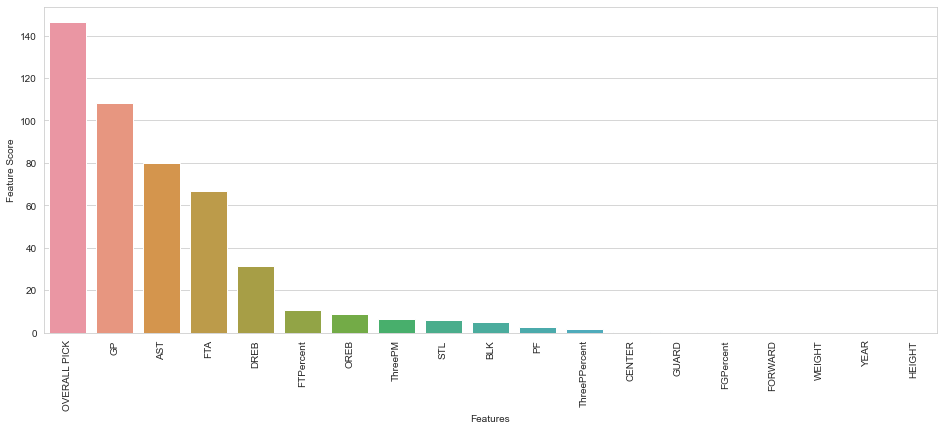

In [742]:
plt.figure(figsize=(16, 6))
bar = sns.barplot(x="Features", y="Feature Score", data=fs1_df)
plt.xticks(rotation = 90)
plt.show()

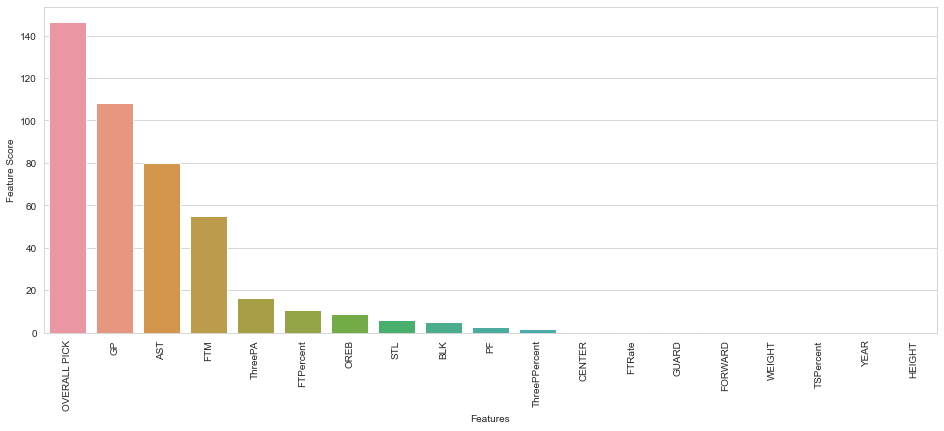

In [743]:
plt.figure(figsize=(16, 6))
bar = sns.barplot(x="Features", y="Feature Score", data=fs2_df)
plt.xticks(rotation = 90)
plt.show()

In [744]:
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k=10)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs

In [745]:
X_train1_fs, X_test1_fs = select_features(X_train1, y_train1, X_test1)
model1 = LogisticRegression(solver='lbfgs', max_iter=1000)
model1.fit(X_train1_fs, y_train1)

LogisticRegression(max_iter=1000)

In [746]:
y_hat1 = model1.predict(X_test1_fs)
chi_score1 = accuracy_score(y_test1, y_hat1)

In [747]:
model2 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state = 1)
model2.fit(X_train1, y_train1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [748]:
y_hat2 = model2.predict(X_test1)
xgb_score1 = accuracy_score(y_test1, y_hat2)

In [749]:
model3 = RandomForestClassifier(n_estimators=1000, random_state = 1)
model3.fit(X_train1, y_train1)

RandomForestClassifier(n_estimators=1000)

In [750]:
y_hat3 = model3.predict(X_test1)
rfr_score1 = accuracy_score(y_test1, y_hat3)

In [751]:
X_train2_fs, X_test2_fs = select_features(X_train2, y_train2, X_test2)
model4 = LogisticRegression(solver='lbfgs', max_iter=1000)
model4.fit(X_train2_fs, y_train2)

LogisticRegression(max_iter=1000)

In [752]:
y_hat4 = model4.predict(X_test2_fs)
chi_score2 = accuracy_score(y_test2, y_hat4)

In [753]:
model5 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state = 1)
model5.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [754]:
y_hat5 = model5.predict(X_test2)
xgb_score2 = accuracy_score(y_test2, y_hat5)

In [755]:
model6 = RandomForestClassifier(n_estimators=1000, random_state = 1)
model6.fit(X_train2, y_train2)

RandomForestClassifier(n_estimators=1000)

In [756]:
y_hat6 = model6.predict(X_test2)
rfr_score2 = accuracy_score(y_test2, y_hat6)

In [757]:
print("Chi2 score1: ", chi_score1) #checking scores for 6 models, 3 diff strategies with two training sets each
print("XGB score1: ", xgb_score1)
print("rfr_score1: ", rfr_score1)
print("Chi2 score2: ", chi_score2) #The chi2 model with features is the best model
print("XGB score2: ", xgb_score2)
print("rfr_score2: ", rfr_score2)

Chi2 score1:  0.9787234042553191
XGB score1:  0.9716312056737588
rfr_score1:  0.9716312056737588
Chi2 score2:  0.9858156028368794
XGB score2:  0.9716312056737588
rfr_score2:  0.975177304964539


In [758]:
y_hats  = pd.DataFrame(data=y_hat4, index=X_test2.index.copy(), columns=["PRED ROTY"])

In [759]:
y_apd = pd.merge(y_test2, y_hats, right_index=True, left_index=True)

In [760]:
correct = 0
wrong = 0
missed = 0
clst = []
wlst = []
mlst = []
for index, row in y_apd.iterrows(): #checking to see what I got correct vs what was missed or wrong
    if row['ROTY'] == 1 and row['PRED ROTY'] == 1:
        correct += 1
        clst += [df_past.loc[index, "PLAYER"]]
    elif row['ROTY'] == 0 and row['PRED ROTY'] == 1:
        wrong += 1
        wlst += [df_past.loc[index, "PLAYER"]]
    elif row['ROTY'] == 1 and row['PRED ROTY'] == 0:
        missed += 1
        mlst += [df_past.loc[index, "PLAYER"]]

print("correct: ", correct, clst)
print("wrong: ", wrong, wlst)
print("missed: ", missed, mlst)

correct:  4 ['Blake Griffin', 'Ja Morant', 'Chris Paul', 'LeBron James']
wrong:  0 []
missed:  4 ['Karl-Anthony Towns', 'Brandon Roy', 'Derrick Rose', "Amar'e Stoudemire"]


In [761]:
weights = np.linspace(0.0,0.99,200) #Range for class weights
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]} 
#Dictionary for grid search

In [762]:
gridsearch = GridSearchCV(estimator= model4, #checking optimal class weights due to uneven distribution of data
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring="f1", 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\asimp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

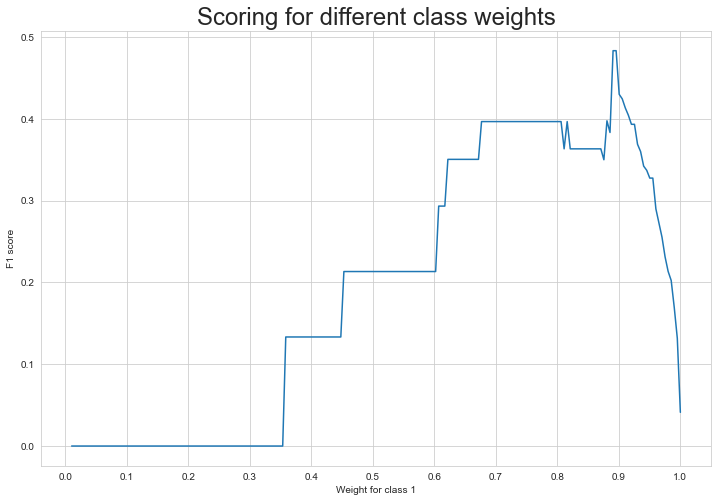

In [763]:
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [764]:
gridsearch.best_estimator_

LogisticRegression(class_weight={0: 0.10447236180904523, 1: 0.8955276381909547},
                   max_iter=1000)

In [766]:
model4v1 = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight={0: 0.10447236180904523, 1: 0.8955276381909547})
model4v1.fit(X_train2_fs, y_train2)

LogisticRegression(class_weight={0: 0.10447236180904523, 1: 0.8955276381909547},
                   max_iter=1000)

In [769]:
y_hat4v1 = model4v1.predict(X_test2_fs)

In [770]:
chi_score2v1 = accuracy_score(y_test2, y_hat4v1)
chi_score2v1 #class weights negatively effects score

0.9787234042553191

Best Threshold=0.195734, F-Score=0.750


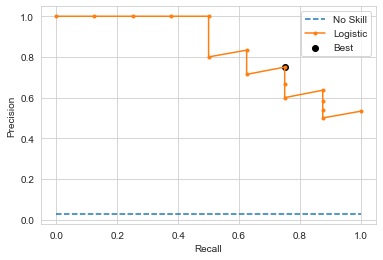

In [771]:
yv1_prob = model4.predict_proba(X_test2_fs) #predicts probabilities for y_test
yv1_prob = yv1_prob[:, 1] #selects only ROTY's

precision, recall, thresholds = precision_recall_curve(y_test2, yv1_prob) #probability threshold for selecting a 
                                                                          #prediction as 1

fscore = (2 * precision * recall) / (precision + recall)

ix = argmax(fscore) # locate the index of the largest f score
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

no_skill = len(y_test2[y_test2==1]) / len(y_test2)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [775]:
X_train2_fs, X_test2_fs = select_features(X_train2, y_train2, X_test2)
model4v2 = LogisticRegression(solver='lbfgs', max_iter=1000)
model4v2.fit(X_train2_fs, y_train2)

LogisticRegression(max_iter=1000)

In [776]:
THRESHOLD = 0.195734
y_hatv2 = np.where(model4v2.predict_proba(X_test2_fs)[:,1] > THRESHOLD, 1, 0)

In [777]:
chi_scorev2 = accuracy_score(y_test, y_hatv2)
chi_scorev2 #adding threshold negatively effected score

0.9822695035460993

In [346]:
transform = SelectKBest(score_func=chi2, k=10)
transform.fit(X_train2, y_train2)
X_train2_fs = transform.transform(X_train2)

In [352]:
pickl = {'transform': transform}
pickle.dump(pickl, open('transform_file' + '.p', 'wb')) #creates restful flask

In [353]:
best_model = model4
best_model.fit(X_train2_fs, y_train2)

LogisticRegression(max_iter=1000, random_state=1)

In [354]:
pickl = {'model': best_model}
pickle.dump(pickl, open('model_file' + '.p', 'wb')) #must move both files to model folder in FlaskAPI for API to work